# Part1: Implementing the Eigenvalue and Harris corner detectors (60 points):

Implement corner detectors based both on the minimum Eigenvalue and the Harrish measure. The corner detectors should be coded in a function called `cornerDetect(img, winSize=7, type=0)`,

where the input arguments are

```
img = image # we are only doing grayscale images,

winSize = total size of window for summation in pixels,

type = {0 – Eigenvalue, 1 – Harris}
```

The function should return the corner strength as a numpy array that has the same size as your input image.

The steps the function has to do are:

1. Filter img with Sobel kernel to obtain derivatives Ix, Iy
2. For each pixel in img, determine second moment matrix H summed up over the window
3. Depending on type, either determine the minimum eigenvalue [using numpy functionality] OR the Harris corner measure and store in return array

Test your corner detector on this picture

https://users.fmrib.ox.ac.uk/~steve/susan/susan/img74.gif

[Read this with matplotlib! Depending on your installation of matplotlib, you will need to convert this to PNG first, since some installations can only read PNG. Again, do NOT use OpenCV!]

Test the picture with `window sizes (3,5,7,9,11,15,21)` for both types of corner measures and TIME the speed. For each window size, plot the output of the corner measures in a nice way like shown during class. Plot the overall speed comparing the two measures in another plot.

In the ipython notebook, answer the following questions:

1. At which window sizes can you detect all “meaningful” corners?
2. Which method is faster – Eigenvalue or Harris? By how much?

# Setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np 
import pandas as pd 

import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from tqdm.auto import tqdm

import cv2 as cv

import ipywidgets

In [2]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

# Load image

In [3]:
# Convert gif into png using web-service in https://ezgif.com
img = plt.imread('img74.png')
img = rgb2gray(img)

# Eigenvalue and Herris corner detection in gray-scale image

In [4]:
def convolution(img: np.array, weights: np.array):
    """
    Convolution with weights filter
    
    Arguments
    ---------
    - img      : image
    - weights  : filter weights
    
    Return
    ------
    - filtered : filtered image
    
    """
    weights = weights.astype(float)
    filtered = np.zeros_like(img)
    
    width = int((weights.shape[1]-1)/2)
    height = int((weights.shape[0]-1)/2)
    
    for i in range(height,img.shape[1]-height):
        for j in range(width,img.shape[0]-width):
            filtered[j,i]=np.sum(weights*img[j-width:j+width+1,i-height:i+height+1])
            
    return filtered

def cornerDetect(img: np.array, winSize: int = 7, type: int = 0):
    """
    Corner Detection
    
    Arguments
    ---------
    - img     : image # we are only doing grayscale images,
    - winSize : total size of window for summation in pixels,
    - type    : {0 – Eigenvalue, 1 – Harris}
    
    Return
    ------
    - l1      : detected corner array by Eigenvalue
    - h       : detected corner array by Herris
    """
    
    # sobel filter by axis
    filter_sobelx = np.array([
        (-1,0,1),
        (-2,0,2),
        (-1,0,1)
    ])
    filter_sobely = np.array([
        (-1,-2,-1),
        (0,0,0),
        (1,2,1)
    ])
    
    # convolution
    imgdx = convolution(img, 1/8*filter_sobelx)
    imgdy = convolution(img, 1/8*filter_sobely)
    
    # define array
    corner = np.zeros_like(img)
    
    # Ixx, Iyy, Ixy
    ix2 = imgdx*imgdx
    iy2 = imgdy*imgdy
    ixy = imgdx*imgdy
    
    # calcuate Eigenvalue and Herris by window
    for y in range(0+winSize, img.shape[0]-1-winSize):
        for x in range(0+winSize, img.shape[1]-1-winSize):
            sx2 = np.sum(ix2[y-winSize:y+winSize, x-winSize:x+winSize])
            sy2 = np.sum(iy2[y-winSize:y+winSize, x-winSize:x+winSize])
            sxy = np.sum(ixy[y-winSize:y+winSize, x-winSize:x+winSize])
            
            # H
            tmpH = np.array([(sx2,sxy), (sxy,sy2)])

            if type==0:
                # Eigenvalues
                corner[y,x], _ = np.sort(np.linalg.eigvals(tmpH))
            elif type==1:
                # Herris
                ttmp = np.trace(tmpH)
                if ttmp != 0:
                    corner[y,x] = np.linalg.det(tmpH)/ttmp
            
    return corner          

We run `cornerDetect` function on 10 iterations to compare the computational time between the two methods. It takes about **20 minutes.**

If `nb_valid_step` is reduced to 1, the computational time may be reduced to about **two minutes**, but the calculation results may not be accurate. 

In [5]:
# window size list
winSize_lst = (3,5,7,9,11,15,21)

# define result list
eigen_result = []
eigen_time = []
herris_result = []
herris_time = []

# if you want to reduce computational time, change it to a small number
nb_valid_step = 10 

# Corner detection by window size
for idx, winSize in enumerate(tqdm(winSize_lst, desc='Window Size')):
    eigen_time_i = []
    herris_time_i = []
    eigen_result.append(cornerDetect(img, winSize=winSize, type=0))
    herris_result.append(cornerDetect(img, winSize=winSize, type=1)) 
    # iteration to valifying computation time
    for _ in tqdm(range(nb_valid_step), desc='VALID', leave=False):
        # Eigenvalue corner detection
        start = time.time()
        _ = cornerDetect(img, winSize=winSize, type=0)
        eigen_time_i.append(time.time() - start)

        # Herris corner detection
        start = time.time()
        _ = cornerDetect(img, winSize=winSize, type=1)
        herris_time_i.append(time.time() - start)
        
    eigen_time.append(eigen_time_i)
    herris_time.append(herris_time_i)

## Q1. At which window sizes can you detect all "meaningful" corners?

As a result of visualiation and comparison by window size, window size **3** was the most appropriate. Because almost corners of shape was detected. We used threshold 0.5 which had been found experimentally. Herris corner detection was the most effective method to detect corners in images. 

In [6]:
def plotting_corner_result(threshold):
    len_winSize_lst = len(winSize_lst)

    fig, ax = plt.subplots(len_winSize_lst, 2, figsize=(12,36))

    for i in range(len_winSize_lst):
        # Eigenvalue
        eigen_cor = eigen_result[i] > threshold
        eigen_cor_x = np.argwhere(eigen_cor==True)[:,1]
        eigen_cor_y = np.argwhere(eigen_cor==True)[:,0]
        
        ax[i,0].imshow(img, cmap='gray')
        ax[i,0].scatter(eigen_cor_x, eigen_cor_y, color='red')
        ax[i,0].set_title(f'Eigenvalue Corner Detection [Window Size {winSize_lst[i]}]',size=15)


        # Herris
        herris_cor = herris_result[i] > threshold
        herris_cor_x = np.argwhere(herris_cor==True)[:,1]
        herris_cor_y = np.argwhere(herris_cor==True)[:,0]
        
        ax[i,1].imshow(img, cmap='gray')
        ax[i,1].scatter(herris_cor_x, herris_cor_y, color='red')
        ax[i,1].set_title(f'Herris Corner Detection [Window Size {winSize_lst[i]}]',size=15)

    plt.tight_layout()
    plt.show()

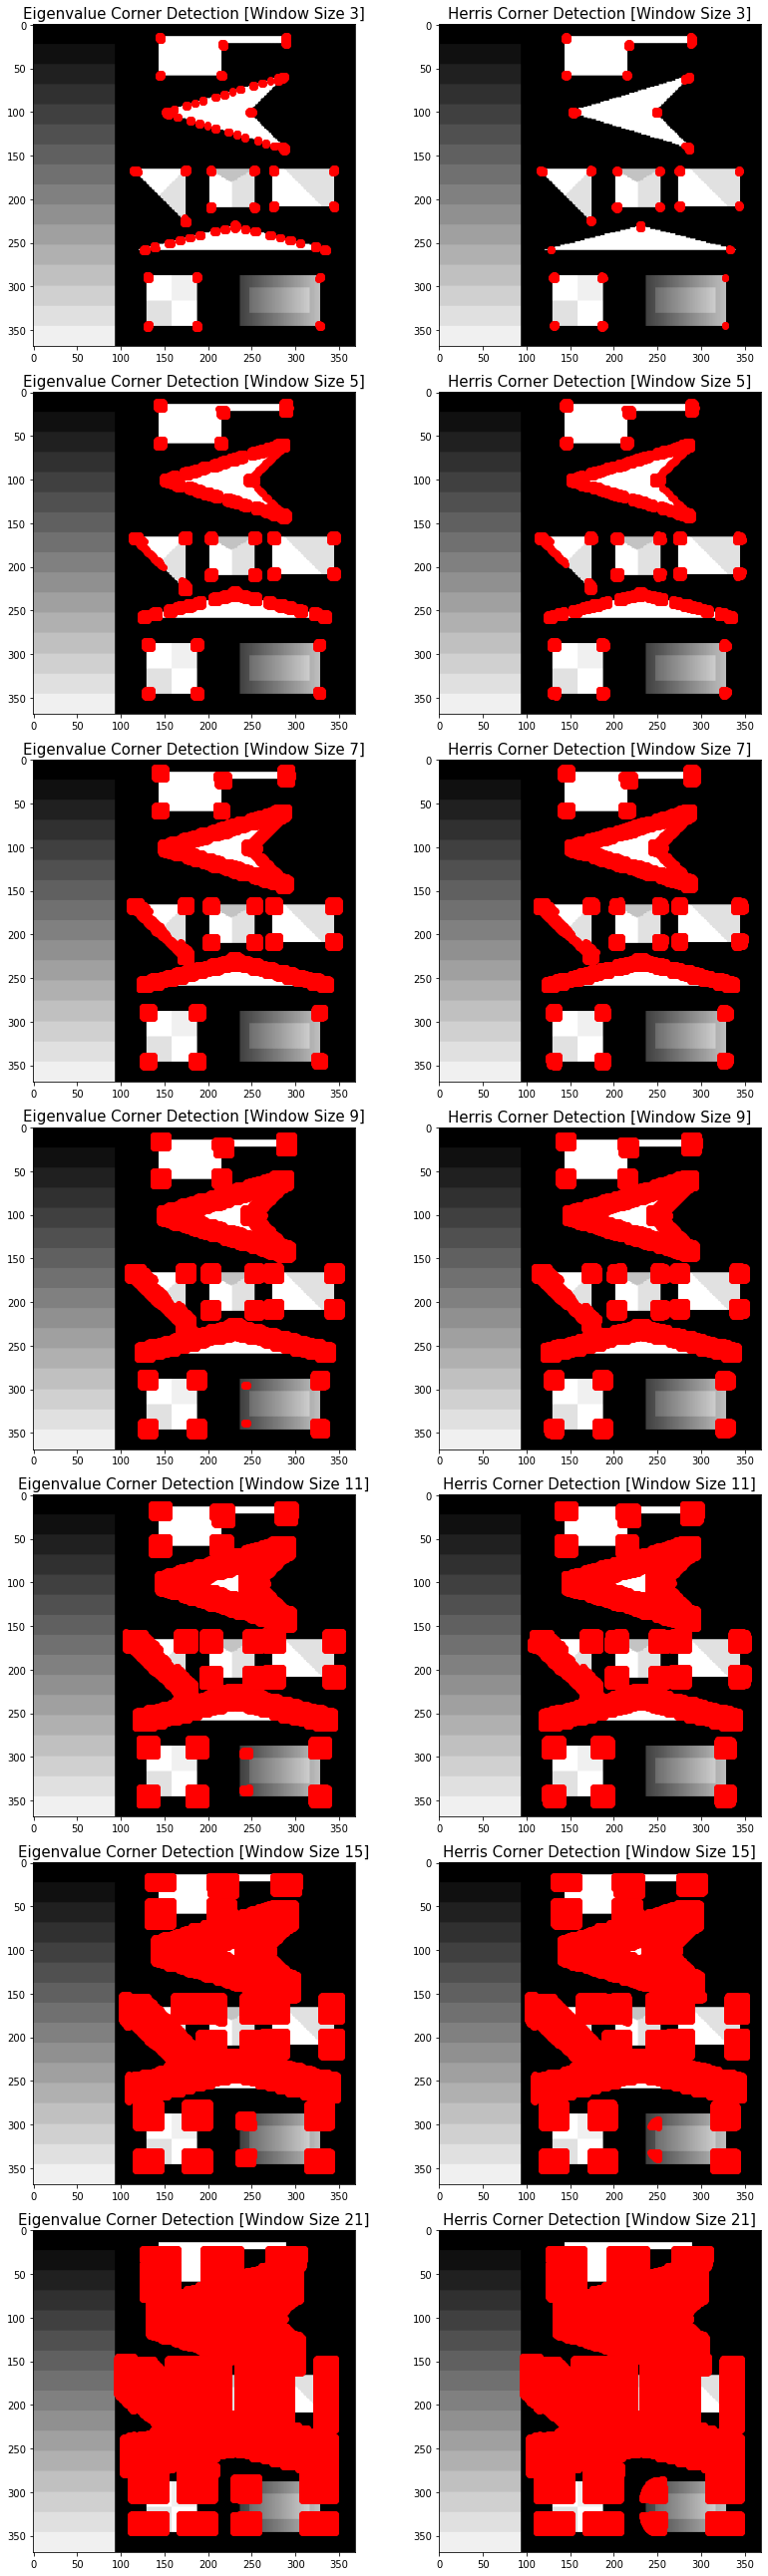

In [24]:
plotting_corner_result(threshold=0.5)

If you want to check the result using another threshold, you can run the code below.

In [15]:
threshold = ipywidgets.IntSlider(value=0, min=0, max=100, step=1)
ipywidgets.interactive(plotting_corner_result, threshold=threshold)

interactive(children=(IntSlider(value=0, description='threshold'), Output()), _dom_classes=('widget-interact',…

## Q2. Which method is faster - Eigenvalue or Harris? By how much?

We run `cornerDetect` function on 10 iterations to compare the computational time between the two methods. As a result, Herris was approximately 1.5 times faster than Eigenvalue at window size 3. However, the time difference between two methods decreased as window size increased. Changin windown size from 3 to 21 reduced the time difference from 2.9 to 1.3 seconds. 

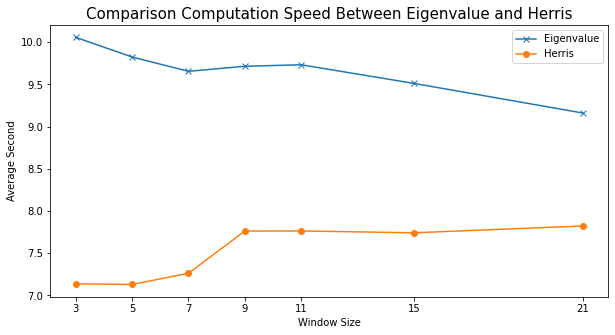

In [8]:
eigen_time_mean = [np.mean(t) for t in eigen_time]
herris_time_mean = [np.mean(t) for t in herris_time]

plt.figure(figsize=(10,5))
plt.plot(winSize_lst, eigen_time_mean, marker='x')
plt.plot(winSize_lst, herris_time_mean, marker='o')
plt.legend(['Eigenvalue','Herris'], loc='upper right')
plt.ylabel('Average Second')
plt.xlabel('Window Size')
plt.xticks(winSize_lst)
plt.title('Comparison Computation Speed Between Eigenvalue and Herris',size=15)
plt.show()

In [9]:
pd.DataFrame({
    'Eigenvalue Mean (sec)': [np.mean(t) for t in eigen_time],
    'Eigenvalue Std (sec)': [np.std(t) for t in eigen_time],
    'Herris Mean (sec)': [np.mean(t) for t in herris_time],
    'Herris Std (sec)': [np.std(t) for t in herris_time],
})

,Eigenvalue Mean (sec),Eigenvalue Std (sec),Herris Mean (sec),Herris Std (sec)
0,10.055979,0.360327,7.137714,0.121353
1,9.823562,0.215748,7.129799,0.190094
2,9.653949,0.202171,7.261532,0.222437
3,9.713519,0.237311,7.761955,0.364749
4,9.731156,0.378299,7.763540,0.229432
5,9.510897,0.246150,7.741528,0.300244
6,9.159518,0.452645,7.822092,0.281031


---

# Bonus

**(10 points)**

Extend the `cornerDetect` function such that it works with color images – note that it should NOT create three images, but still only one corner value, but now taking into account all three color channels. Insert the code as a function `cornerDetectColor` and plot the results for this picture:

https://miro.medium.com/max/700/1*KvDEGIpfwdJtUFwB5acYEA.png

In [10]:
def cornerDetectColor(img: np.array, winSize: int = 7, type: int = 0):
    """
    Corner Detection in color image
    
    Arguments
    ---------
    - img     : image 
    - winSize : total size of window for summation in pixels,
    - type    : {0 – Eigenvalue, 1 – Harris}
    
    Return
    ------
    - l1      : detected corner array by Eigenvalue
    - h       : detected corner array by Herris
    """
    
    # sobel filter by axis
    filter_sobelx = np.array([
        (-1,0,1),
        (-2,0,2),
        (-1,0,1)
    ])
    filter_sobely = np.array([
        (-1,-2,-1),
        (0,0,0),
        (1,2,1)
    ])
    
    # define array
    corner = []
    
    # calcuate Eigenvalue and Herris by window
    for c in range(img.shape[2]):
        # convolution
        img_c = img[...,c]
        
        imgdx = convolution(img_c, 1/8*filter_sobelx)
        imgdy = convolution(img_c, 1/8*filter_sobely)

        # Ixx, Iyy, Ixy
        ix2 = imgdx*imgdx
        iy2 = imgdy*imgdy
        ixy = imgdx*imgdy
        corner_i = np.zeros_like(img_c)
        for y in range(0+winSize, img_c.shape[0]-1-winSize):
            for x in range(0+winSize, img_c.shape[1]-1-winSize):
                # average each channel results
                sx2 = np.sum(ix2[y-winSize:y+winSize, x-winSize:x+winSize])
                sy2 = np.sum(iy2[y-winSize:y+winSize, x-winSize:x+winSize])
                sxy = np.sum(ixy[y-winSize:y+winSize, x-winSize:x+winSize])
                
                # H
                tmpH = np.array([(sx2,sxy), (sxy,sy2)])

                if type==0:
                    # Eigenvalues
                    corner_i[y,x], _ = np.sort(np.linalg.eigvals(tmpH))
                elif type==1:
                    # Herris
                    ttmp = np.trace(tmpH)
                    if ttmp != 0:
                        corner_i[y,x] = np.linalg.det(tmpH)/ttmp
    
        corner.append(corner_i)
    
    corner = np.mean(corner, axis=0)
            
    return corner

In [11]:
color_img = plt.imread('color_img.png')

winSize_lst = (3,5,7,9,11,15,21)
eigen_color_result = []
herris_color_result = []

# Corner detection by window size
for idx, winSize in enumerate(tqdm(winSize_lst)):
    # Eigenvalue corner detection
    eigen_color_result.append(cornerDetectColor(color_img, winSize=winSize, type=0))
    
    # Herris corner detection
    herris_color_result.append(cornerDetectColor(color_img, winSize=winSize, type=1))    

In [12]:
def plotting_color_corner_result(threshold):
    len_winSize_lst = len(winSize_lst)

    fig, ax = plt.subplots(len_winSize_lst, 2, figsize=(12,36))

    for i in range(len_winSize_lst):
        # Eigenvalue 
        eigen_cor = eigen_color_result[i] > threshold
        eigen_cor_x = np.argwhere(eigen_cor==True)[:,1]
        eigen_cor_y = np.argwhere(eigen_cor==True)[:,0]

        # Herris
        herris_cor = herris_color_result[i] > threshold
        herris_cor_x = np.argwhere(herris_cor==True)[:,1]
        herris_cor_y = np.argwhere(herris_cor==True)[:,0]

        ax[i,0].imshow(color_img, cmap='gray')
        ax[i,0].scatter(eigen_cor_x, eigen_cor_y, color='red')
        ax[i,0].set_title(f'Eigenvalue Corner Detection [Window Size {winSize_lst[i]}]',size=15)

        ax[i,1].imshow(color_img, cmap='gray')
        ax[i,1].scatter(herris_cor_x, herris_cor_y, color='red')
        ax[i,1].set_title(f'Herris Corner Detection [Window Size {winSize_lst[i]}]',size=15)
        
    plt.tight_layout()
    plt.show()

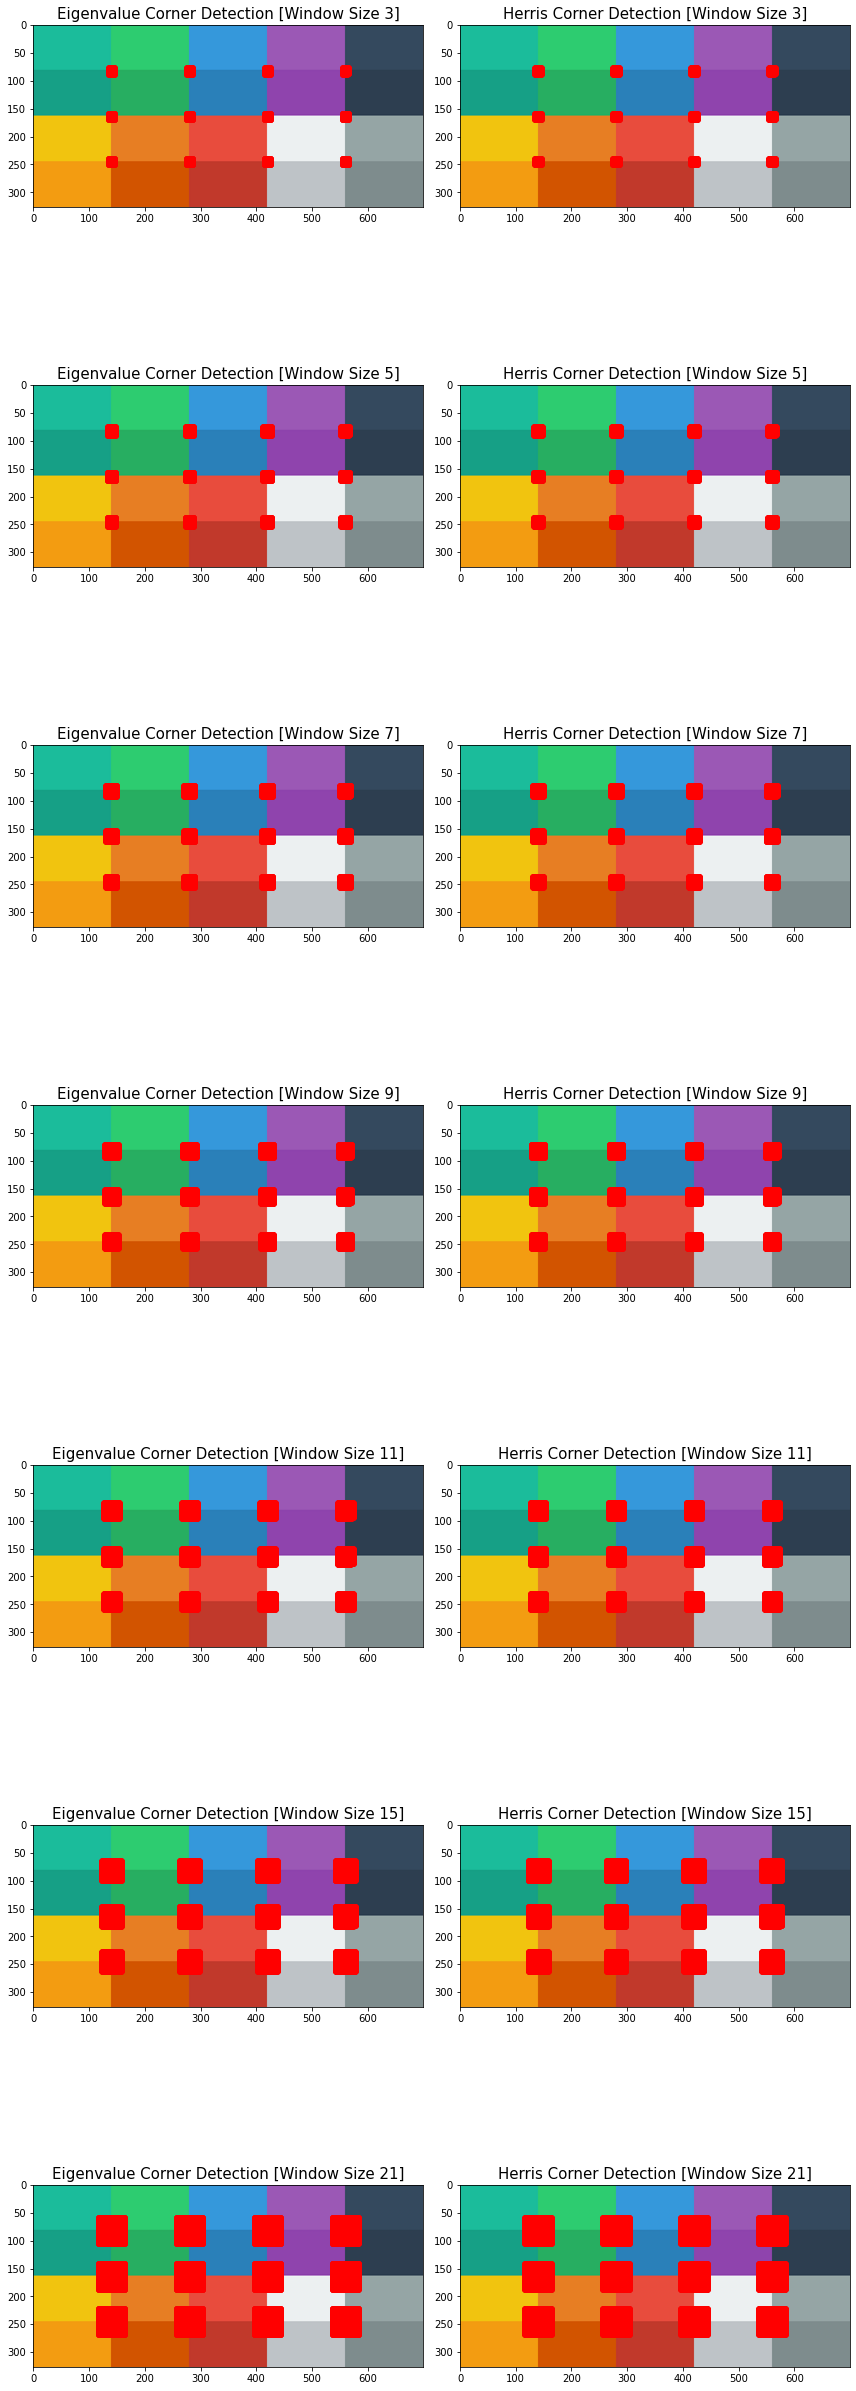

In [18]:
plotting_color_corner_result(threshold=0)

If you want to check the result using another threshold, you can run the code below.

In [13]:
threshold = ipywidgets.FloatSlider(value=0, min=0, max=10, step=0.1)
ipywidgets.interactive(plotting_color_corner_result, threshold=threshold)

interactive(children=(FloatSlider(value=0.0, description='threshold', max=10.0), Output()), _dom_classes=('wid…